In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
from sklearn import datasets

digit = datasets.load_digits()
print(digit.data,digit.target)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]] [0 1 2 ... 8 9 8]


In [32]:
digit.data.shape

(1797, 64)

In [33]:
len(digit.data)

1797

#### model configuration  
convolutional layer 는 총 2개로 설정  
pooling 방식은 maxpooling  
마지막 dense layer는 view method를 사용하여 데이터 변환후 linear 유닛으로 변경  


- last layer에 softmax 사용안하는 이유  
   :nn.CrossEntropyLoss()는 내부적으로 LogSoftmax + NLLLoss를 결합해서 계산   
   마지막 레이어에 softmax를 추가하면, softmax가 두 번 적용되어 학습이 제대로 되지 않음  

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 10)  # digits 데이터셋은 10개 클래스

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 생성 예시
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


#### 데이터 분할  

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digit.data, digit.target, test_size=0.2, random_state=0)

In [36]:
X_train = torch.tensor(X_train, dtype=torch.int64)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [37]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### loss funtion 및 옵티마이저 설정  
- 다중분류가 목적이므로 crossentropyloss  

In [38]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
train_losses = []
test_accuracies = []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_dataloader:
        # 입력 데이터 shape 변환: (batch, 64) -> (batch, 1, 8, 8)
        batch_x = batch_x.float().view(-1, 1, 8, 8)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))
    # 테스트 정확도 계산
    model.eval()
    with torch.no_grad():
        test_x = X_test.float().view(-1, 1, 8, 8)
        test_outputs = model(test_x)
        _, predicted = torch.max(test_outputs.data, 1)
        correct = (predicted == y_test).sum().item()
        accuracy = correct / len(y_test)
        test_accuracies.append(accuracy)
        print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")



Test Accuracy: 0.8250
Epoch 1/50, Loss: 1.7527, Accuracy: 0.82%
Test Accuracy: 0.9028
Epoch 2/50, Loss: 0.5459, Accuracy: 0.90%
Test Accuracy: 0.9667
Epoch 3/50, Loss: 0.2129, Accuracy: 0.97%
Test Accuracy: 0.9417
Epoch 4/50, Loss: 0.1466, Accuracy: 0.94%
Test Accuracy: 0.9556
Epoch 5/50, Loss: 0.1113, Accuracy: 0.96%
Test Accuracy: 0.9778
Epoch 6/50, Loss: 0.0974, Accuracy: 0.98%
Test Accuracy: 0.9750
Epoch 7/50, Loss: 0.0588, Accuracy: 0.97%
Test Accuracy: 0.9833
Epoch 8/50, Loss: 0.0422, Accuracy: 0.98%
Test Accuracy: 0.9778
Epoch 9/50, Loss: 0.0401, Accuracy: 0.98%
Test Accuracy: 0.9833
Epoch 10/50, Loss: 0.0291, Accuracy: 0.98%
Test Accuracy: 0.9750
Epoch 11/50, Loss: 0.0269, Accuracy: 0.97%
Test Accuracy: 0.9889
Epoch 12/50, Loss: 0.0260, Accuracy: 0.99%
Test Accuracy: 0.9889
Epoch 13/50, Loss: 0.0172, Accuracy: 0.99%
Test Accuracy: 0.9806
Epoch 14/50, Loss: 0.0112, Accuracy: 0.98%
Test Accuracy: 0.9833
Epoch 15/50, Loss: 0.0097, Accuracy: 0.98%
Test Accuracy: 0.9833
Epoch 16/50,

#### 모델 평가 지표  

In [40]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# 모델 평가 모드로 변경
model.eval()

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 모델을 GPU로 이동

# 결과 저장
all_labels = []
all_predictions = []

# 평가 데이터 처리
with torch.no_grad():
    for batch_x, batch_y in train_dataloader:
        # 입력 데이터 shape 변환: (batch, 64) -> (batch, 1, 8, 8)
        batch_x = batch_x.float().view(-1, 1, 8, 8).to(device)  # GPU로 이동
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)  # 수정: torch.max의 반환값 언패킹
        
        all_labels.extend(batch_y.cpu().numpy())  # CPU로 이동 후 numpy로 변환
        all_predictions.extend(predicted.cpu().numpy())  # CPU로 이동 후 numpy로 변환

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

# 결과 출력
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[151   0   0   0   0   0   0   0   0   0]
 [  0 147   0   0   0   0   0   0   0   0]
 [  0   0 141   0   0   0   0   0   0   0]
 [  0   0   0 154   0   0   0   0   0   0]
 [  0   0   0   0 151   0   0   0   0   0]
 [  0   0   0   0   0 142   0   0   0   0]
 [  0   0   0   0   0   0 137   0   0   0]
 [  0   0   0   0   0   0   0 140   0   0]
 [  0   0   0   0   0   0   0   0 135   0]
 [  0   0   0   0   0   0   0   0   0 139]]
F1 Score: 1.00
Precision: 1.00
Recall: 1.00
Specificity: 1.00


#### 시각화   

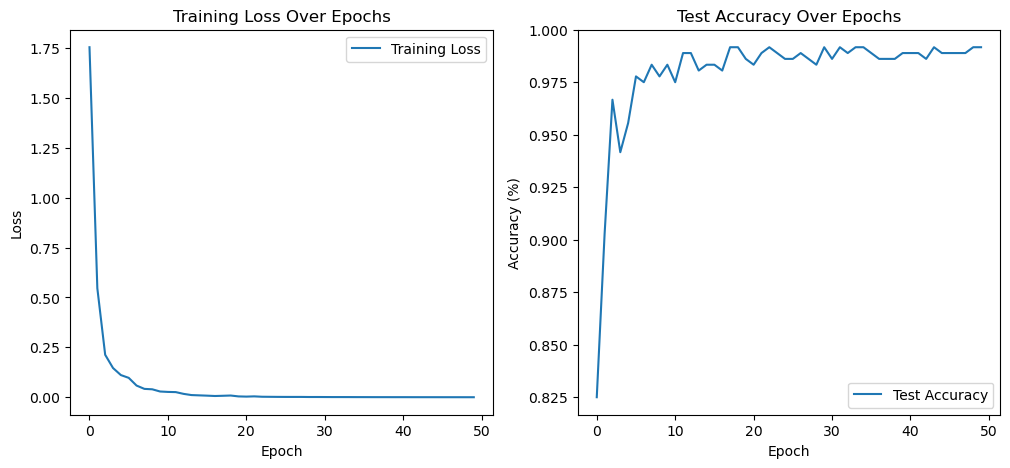

In [41]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()